In [1]:
import sys
!git clone https://github.com/z5365195Yuhao/elpv-dataset.git
sys.path.insert(0,'/content/elpv-dataset/utils')
from elpv_reader import load_dataset

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2689, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2689 (delta 0), reused 0 (delta 0), pack-reused 2688
Receiving objects: 100% (2689/2689), 90.79 MiB | 14.18 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from torchvision import transforms, models
from collections import Counter

# Simple CNN

## Load Data

In [3]:
images, proba, types = load_dataset()
proba = np.around(proba, decimals=1)

Define the model and train function:

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2)
        self.conv2 = nn.Conv2d(8, 64, 3, stride=2)
        self.conv3 = nn.Conv2d(64, 512, 3, stride=2)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(165888, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [5]:
# Define the training loop
def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

        # Validation
        model.eval()
        # get the accuracy for all the types
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Overall Accuracy after epoch {epoch+1}: {accuracy * 100:.2f}%')

        if epoch == num_epochs - 1:
            f1 = f1_score(all_labels, all_preds, average='weighted')
            cm = confusion_matrix(all_labels, all_preds)
            print(f'F1 Score after last epoch: {f1:.4f}')
            print(f'Confusion Matrix after last epoch:')
            # Plot the confusion matrix using Seaborn
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt='d')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

        # get the accuracy for all the type mono
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_mono_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Mono Accuracy after epoch {epoch+1}: {accuracy * 100:.2f}%')

        if epoch == num_epochs - 1:
            f1 = f1_score(all_labels, all_preds, average='weighted')
            cm = confusion_matrix(all_labels, all_preds)
            print(f'F1 Score after last epoch: {f1:.4f}')
            print(f'Confusion Matrix after last epoch:')
            # Plot the confusion matrix using Seaborn
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt='d')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

        # get the accuracy for all the type poly
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_poly_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Poly Accuracy after epoch {epoch+1}: {accuracy * 100:.2f}%')

        if epoch == num_epochs - 1:
            f1 = f1_score(all_labels, all_preds, average='weighted')
            cm = confusion_matrix(all_labels, all_preds)
            print(f'F1 Score after last epoch: {f1:.4f}')
            print(f'Confusion Matrix after last epoch:')
            # Plot the confusion matrix using Seaborn
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt='d')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

            model_state = model.state_dict()

            weights_layer_1 = model_state['fc1.weight']
            weights_layer_2 = model_state['fc2.weight']
            weights_layer_1 = weights_layer_1.cpu()
            weights_layer_2 = weights_layer_2.cpu()
            weights_layer_1 = weights_layer_1.numpy().ravel()
            weights_layer_2 = weights_layer_2.numpy().ravel()
            small_value_num = np.sum(np.abs(weights_layer_1) < 0.001)
            print(f"{small_value_num/len(weights_layer_1)* 100:.2f}% of the weights in the first fc layer has lower abosolute value than 0.001")










## Split Training and Testing sets

In [6]:
images_train_idx, images_test_idx, labels_train, labels_test = train_test_split(
    range(len(images)), proba, test_size=0.25, random_state=42,stratify = proba)

In [7]:
def split_types(images_test_idx,labels_test):
  list_mono = []
  list_poly = []
  for i in range(len(labels_test)):
    if types[images_test_idx[i]] == "mono":
      list_mono.append(labels_test[i])
    elif types[images_test_idx[i]] == "poly":
      list_poly.append(labels_test[i])
  return np.array(list_mono), np.array(list_poly)


In [8]:
# generate the training and testing data sets
labels_test_mono, labels_test_poly = split_types(images_test_idx,labels_test)
images_train_list = [images[i] for i in images_train_idx]
images_test_list = [images[i] for i in images_test_idx]
images_train = np.array(images_train_list)
images_test = np.array(images_test_list)
images_test_mono, images_test_poly = split_types(images_test_idx,images_test)

In [9]:
# convert the label in labels to 0, 1, 2, 3
proba_to_index = {0: 0, 0.3: 1, 0.7: 2, 1: 3}
def convert_label(labels):
  return [proba_to_index[p] for p in labels]

labels_train, labels_test, labels_test_mono, labels_test_poly = convert_label(labels_train), convert_label(labels_test), convert_label(labels_test_mono),convert_label(labels_test_poly)


## Train model

In [10]:
# Convert to PyTorch tensors and add a channel dimension
images_train_tensor = torch.tensor(images_train.copy(), dtype=torch.float32).unsqueeze(1)
images_test_tensor = torch.tensor(images_test.copy(), dtype=torch.float32).unsqueeze(1)
images_test_mono_tensor = torch.tensor(images_test_mono.copy(), dtype=torch.float32).unsqueeze(1)
images_test_poly_tensor = torch.tensor(images_test_poly.copy(), dtype=torch.float32).unsqueeze(1)


labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)
labels_test_mono_tensor = torch.tensor(labels_test_mono, dtype=torch.long)
labels_test_poly_tensor = torch.tensor(labels_test_poly, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
test_dataset = TensorDataset(images_test_tensor, labels_test_tensor)
test_mono_dataset = TensorDataset(images_test_mono_tensor, labels_test_mono_tensor)
test_poly_dataset = TensorDataset(images_test_poly_tensor, labels_test_poly_tensor)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_mono_loader = DataLoader(test_mono_dataset, batch_size=32, shuffle=False)
test_poly_loader = DataLoader(test_poly_dataset, batch_size=32, shuffle=False)






In [11]:
# Initialize the network, optimizer and loss function
model = Net()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()

Epoch 1, Loss: 1.17264526121078
Overall Accuracy after epoch 1: 57.47%
Mono Accuracy after epoch 1: 56.87%
Poly Accuracy after epoch 1: 57.87%
Epoch 2, Loss: 1.1700793033646
Overall Accuracy after epoch 2: 57.47%
Mono Accuracy after epoch 2: 56.87%
Poly Accuracy after epoch 2: 57.87%
Epoch 3, Loss: 1.1705833452363168
Overall Accuracy after epoch 3: 57.47%
Mono Accuracy after epoch 3: 56.87%
Poly Accuracy after epoch 3: 57.87%
Epoch 4, Loss: 1.1715913924478716
Overall Accuracy after epoch 4: 57.47%
Mono Accuracy after epoch 4: 56.87%
Poly Accuracy after epoch 4: 57.87%
Epoch 5, Loss: 1.1675591497651991
Overall Accuracy after epoch 5: 57.47%
Mono Accuracy after epoch 5: 56.87%
Poly Accuracy after epoch 5: 57.87%
Epoch 6, Loss: 1.16957527014517
Overall Accuracy after epoch 6: 57.47%
Mono Accuracy after epoch 6: 56.87%
Poly Accuracy after epoch 6: 57.87%
Epoch 7, Loss: 1.1680631714482461
Overall Accuracy after epoch 7: 57.47%
Mono Accuracy after epoch 7: 56.87%
Poly Accuracy after epoch 7:

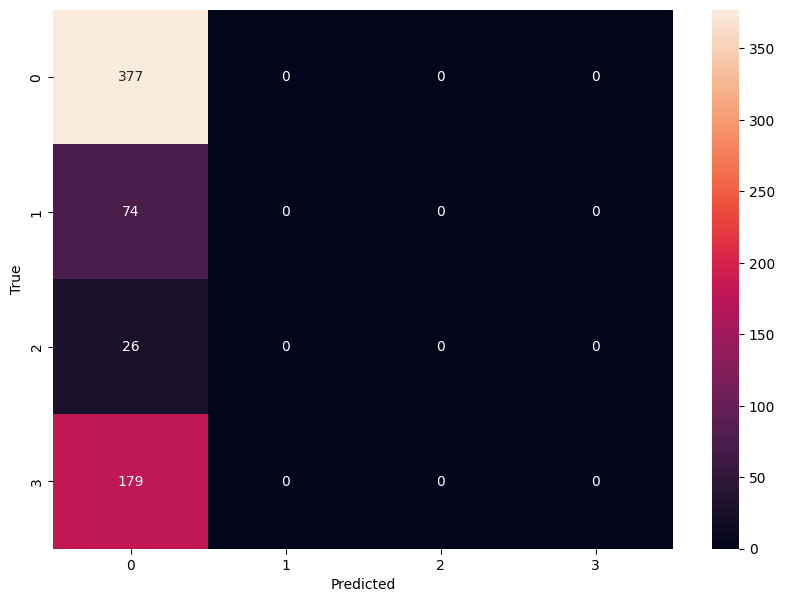

Mono Accuracy after epoch 30: 56.87%
F1 Score after last epoch: 0.4123
Confusion Matrix after last epoch:


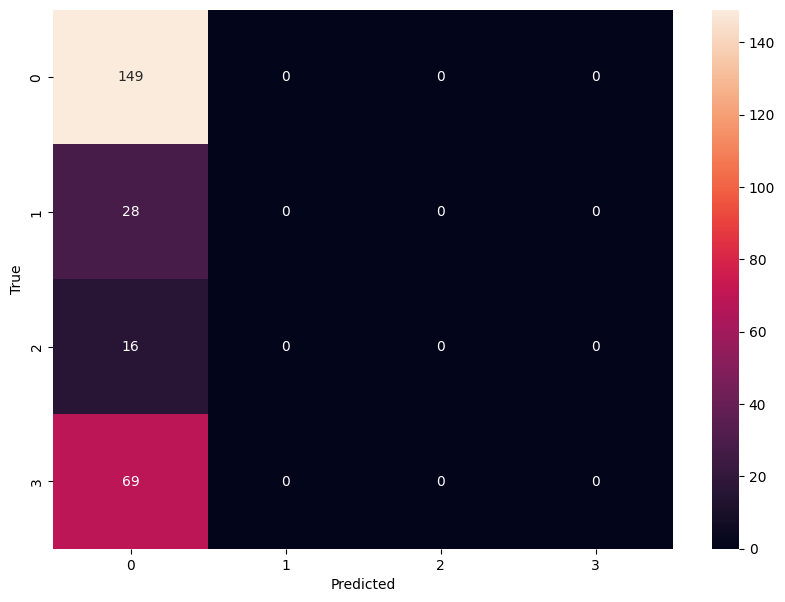

Poly Accuracy after epoch 30: 57.87%
F1 Score after last epoch: 0.4242
Confusion Matrix after last epoch:


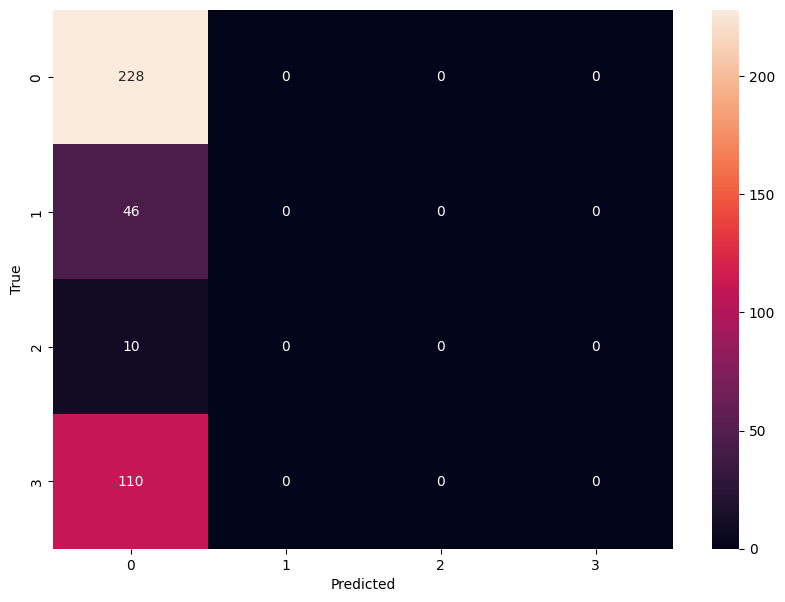

40.73% of the weights in the first fc layer has lower abosolute value than 0.001


In [12]:
train_model(30)

## Train model with augmented data.

In [13]:

def augment(images_train,labels_train):
  images_train_aug = []
  labels_train_aug = []
  for i in range(len(labels_train)):
    # if the proba is 0, append the original image and proba
    if labels_train[i] == 0:
      images_train_aug.append(images_train[i])
      labels_train_aug.append(labels_train[i])

    # if the proba is 1, append the original image and the flipped image with proba,
    elif labels_train[i] == 3:
      images_train_aug.append(images_train[i])
      labels_train_aug.append(labels_train[i])

      # flip through x axis
      image_flipped = cv2.flip(images_train[i], 0)
      images_train_aug.append(image_flipped)
      labels_train_aug.append(labels_train[i])

    # if the proba is 0.3, append the original image, flipped images with different axis,
    # rotated images with different angles with proba
    elif labels_train[i] == 1:
      images_train_aug.append(images_train[i])
      labels_train_aug.append(labels_train[i])

      # flip through x axis
      image_flipped = cv2.flip(images_train[i], 0)
      images_train_aug.append(image_flipped)
      labels_train_aug.append(labels_train[i])

      # flip through y axis
      image_flipped = cv2.flip(images_train[i], 1)
      images_train_aug.append(image_flipped)
      labels_train_aug.append(labels_train[i])

      # rotate 90 clockwise
      image_rotated = cv2.rotate(images_train[i], cv2.ROTATE_90_CLOCKWISE)
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])

      # rotate 90 counterclockwise
      image_rotated = cv2.rotate(images_train[i], cv2.ROTATE_90_COUNTERCLOCKWISE)
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])

      # rotate 180
      image_rotated = cv2.rotate(image_rotated, cv2.ROTATE_90_COUNTERCLOCKWISE)
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])

    elif labels_train[i] == 2:
      images_train_aug.append(images_train[i])
      labels_train_aug.append(labels_train[i])
      images_train_aug.append(images_train[i])
      labels_train_aug.append(labels_train[i])

      # flip through x axis
      image_flipped = cv2.flip(images_train[i], 0)
      images_train_aug.append(image_flipped)
      labels_train_aug.append(labels_train[i])
      images_train_aug.append(image_flipped)
      labels_train_aug.append(labels_train[i])

      # flip through y axis
      image_flipped = cv2.flip(images_train[i], 1)
      images_train_aug.append(image_flipped)
      labels_train_aug.append(labels_train[i])
      images_train_aug.append(image_flipped)
      labels_train_aug.append(labels_train[i])

      # rotate 90 clockwise
      image_rotated = cv2.rotate(images_train[i], cv2.ROTATE_90_CLOCKWISE)
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])

      # rotate 90 counterclockwise
      image_rotated = cv2.rotate(images_train[i], cv2.ROTATE_90_COUNTERCLOCKWISE)
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])

      # rotate 180
      image_rotated = cv2.rotate(image_rotated, cv2.ROTATE_90_COUNTERCLOCKWISE)
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])
      images_train_aug.append(image_rotated)
      labels_train_aug.append(labels_train[i])
  return np.array(images_train_aug),  np.array(labels_train_aug)

In [14]:
# augment training data
images_train_aug, labels_train_aug = augment(images_train,labels_train)

In [15]:
images_train_tensor = torch.tensor(images_train_aug.copy(), dtype=torch.float32).unsqueeze(1)
labels_train_tensor = torch.tensor(labels_train_aug, dtype=torch.long)
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)

Epoch 1, Loss: 1.1701933818478738
Overall Accuracy after epoch 1: 57.47%
Mono Accuracy after epoch 1: 56.87%
Poly Accuracy after epoch 1: 57.87%
Epoch 2, Loss: 1.169071247500758
Overall Accuracy after epoch 2: 57.47%
Mono Accuracy after epoch 2: 56.87%
Poly Accuracy after epoch 2: 57.87%
Epoch 3, Loss: 1.1685672123585977
Overall Accuracy after epoch 3: 57.47%
Mono Accuracy after epoch 3: 56.87%
Poly Accuracy after epoch 3: 57.87%
Epoch 4, Loss: 1.170079308171426
Overall Accuracy after epoch 4: 57.47%
Mono Accuracy after epoch 4: 56.87%
Poly Accuracy after epoch 4: 57.87%
Epoch 5, Loss: 1.1690712446166622
Overall Accuracy after epoch 5: 57.47%
Mono Accuracy after epoch 5: 56.87%
Poly Accuracy after epoch 5: 57.87%
Epoch 6, Loss: 1.1680631724096113
Overall Accuracy after epoch 6: 57.47%
Mono Accuracy after epoch 6: 56.87%
Poly Accuracy after epoch 6: 57.87%
Epoch 7, Loss: 1.1705833308158382
Overall Accuracy after epoch 7: 57.47%
Mono Accuracy after epoch 7: 56.87%
Poly Accuracy after epo

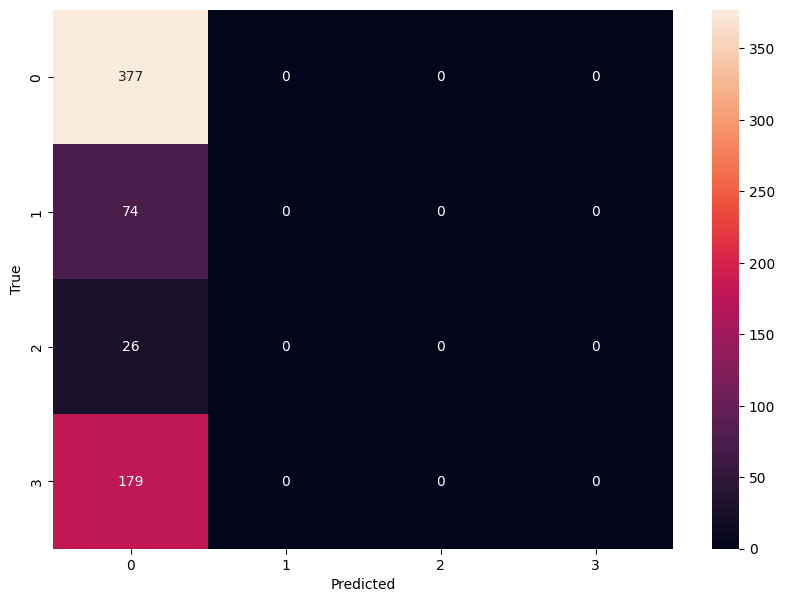

Mono Accuracy after epoch 30: 56.87%
F1 Score after last epoch: 0.4123
Confusion Matrix after last epoch:


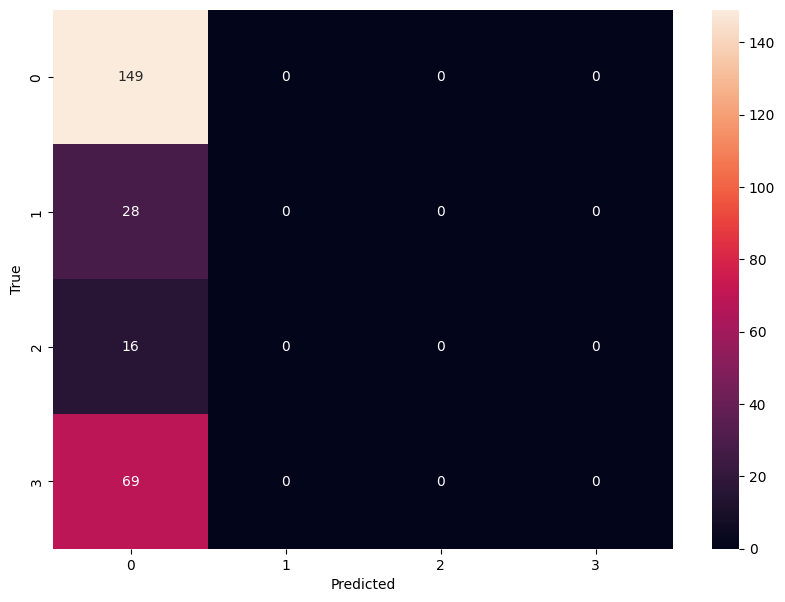

Poly Accuracy after epoch 30: 57.87%
F1 Score after last epoch: 0.4242
Confusion Matrix after last epoch:


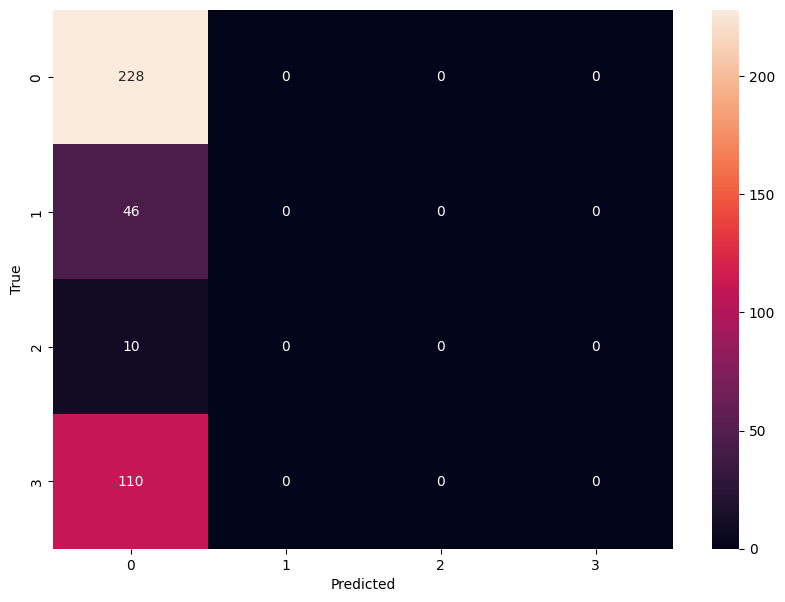

40.73% of the weights in the first fc layer has lower abosolute value than 0.001


In [16]:
# Initialize the network, optimizer and loss function
model = Net()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum = 0.9)
criterion = nn.CrossEntropyLoss()
train_model(30)

# Resnet

## Define the net and train function

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = np.stack((images,) * 3, axis=-1)  # Stack grayscale images along the last dimension
        self.labels = labels.astype(np.int64)  # Ensure labels are integers
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # This will have a shape of (300, 300, 3)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Apply the transform
        return image, torch.tensor(label, dtype=torch.long)

# Now the transform should not include the conversion to RGB as we have already taken care of it
transform = transforms.Compose([
    transforms.ToPILImage(),  # Converts a NumPy array to PIL Image
    transforms.Resize((224, 224)),  # Resize to the input size expected by ResNet
    transforms.ToTensor(),  # Converts to Tensor and scales to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for ResNet
])


In [18]:
# Training loop
def train_model(model,num_epochs):
    acc_list = []
    acc_list_mono = []
    acc_list_poly = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

        # Validation
        model.eval()

        # Validate overall
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        acc_list.append(accuracy)
        print(f'Overall Accuracy after epoch {epoch+1}: {accuracy * 100:.2f}%')

        # After the last epoch calculate F-score and confusion matrix
        if epoch == num_epochs - 1:
            f1 = f1_score(all_labels, all_preds, average='weighted')
            print(f'F1 Score after last epoch: {f1:.4f}')
            cm = confusion_matrix(all_labels, all_preds)

            f = plt.figure(figsize=(20,5))
            f.add_subplot(1,2, 1)
            plt.title("Confusion Matrix")
            sns.heatmap(cm, annot=True, fmt='d')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            f.add_subplot(1,2, 2)
            plt.plot(range(1, num_epochs+1), acc_list, marker='o', linestyle='-', color='blue')
            plt.title('Model Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.show()
            f.show()

        # Validate type mono
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_mono_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        acc_list_mono.append(accuracy)
        print(f'Mono Accuracy after epoch {epoch+1}: {accuracy * 100:.2f}%')

        # After the last epoch calculate F-score and confusion matrix
        if epoch == num_epochs - 1:
            f1 = f1_score(all_labels, all_preds, average='weighted')
            print(f'F1 Score after last epoch: {f1:.4f}')
            cm = confusion_matrix(all_labels, all_preds)

            f = plt.figure(figsize=(20,5))
            f.add_subplot(1,2, 1)
            plt.title("Confusion Matrix")
            sns.heatmap(cm, annot=True, fmt='d')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            f.add_subplot(1,2, 2)
            plt.plot(range(1, num_epochs+1), acc_list_mono, marker='o', linestyle='-', color='blue')
            plt.title('Model Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.show()
            f.show()

        # Validate type mono
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_poly_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        acc_list_poly.append(accuracy)
        print(f'Poly Accuracy after epoch {epoch+1}: {accuracy * 100:.2f}%')

        # After the last epoch calculate F-score and confusion matrix
        if epoch == num_epochs - 1:
            f1 = f1_score(all_labels, all_preds, average='weighted')
            print(f'F1 Score after last epoch: {f1:.4f}')
            cm = confusion_matrix(all_labels, all_preds)

            f = plt.figure(figsize=(20,5))
            f.add_subplot(1,2, 1)
            plt.title("Confusion Matrix")
            sns.heatmap(cm, annot=True, fmt='d')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            f.add_subplot(1,2, 2)
            plt.plot(range(1, num_epochs+1), acc_list_poly, marker='o', linestyle='-', color='blue')
            plt.title('Model Accuracy per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.show()
            f.show()



## Train model

In [21]:
labels_test, labels_test_mono, labels_test_poly = np.array(labels_test), np.array(labels_test_mono), np.array(labels_test_poly)
labels_train = np.array(labels_train)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 1.3034984527095672
Overall Accuracy after epoch 1: 31.55%
Mono Accuracy after epoch 1: 30.53%
Poly Accuracy after epoch 1: 32.23%
Epoch 2, Loss: 1.0661473101185215
Overall Accuracy after epoch 2: 31.71%
Mono Accuracy after epoch 2: 27.86%
Poly Accuracy after epoch 2: 34.26%
Epoch 3, Loss: 0.9642724740889764
Overall Accuracy after epoch 3: 62.35%
Mono Accuracy after epoch 3: 53.82%
Poly Accuracy after epoch 3: 68.02%
Epoch 4, Loss: 0.7734151309536349
Overall Accuracy after epoch 4: 56.86%
Mono Accuracy after epoch 4: 46.56%
Poly Accuracy after epoch 4: 63.71%
Epoch 5, Loss: 0.670580122740038
Overall Accuracy after epoch 5: 51.98%
Mono Accuracy after epoch 5: 44.66%
Poly Accuracy after epoch 5: 56.85%
Epoch 6, Loss: 0.6195562145402355
Overall Accuracy after epoch 6: 67.38%
Mono Accuracy after epoch 6: 70.61%
Poly Accuracy after epoch 6: 65.23%
Epoch 7, Loss: 0.569076213144487
Overall Accuracy after epoch 7: 33.54%
Mono Accuracy after epoch 7: 37.02%
Poly Accuracy after epo

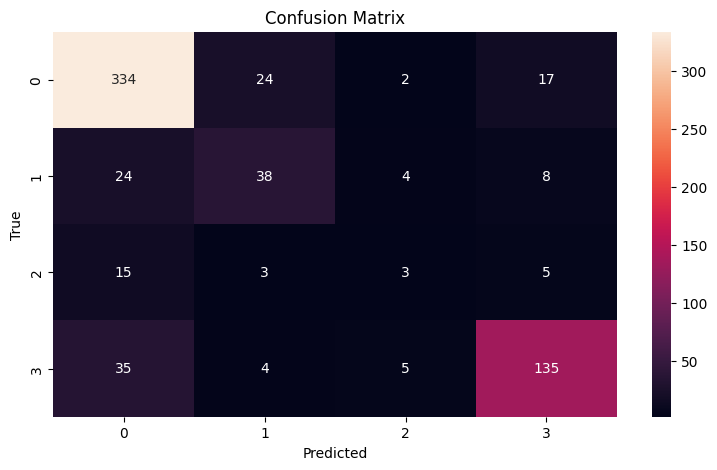

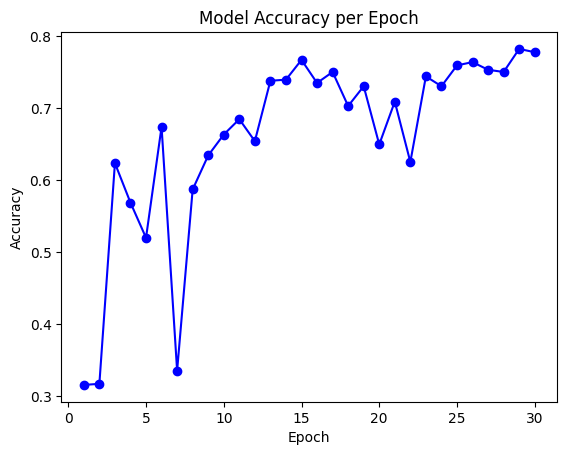

Mono Accuracy after epoch 30: 81.30%
F1 Score after last epoch: 0.8029


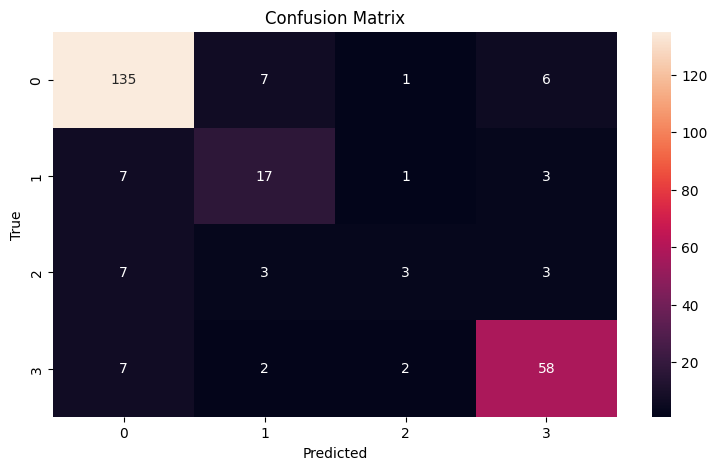

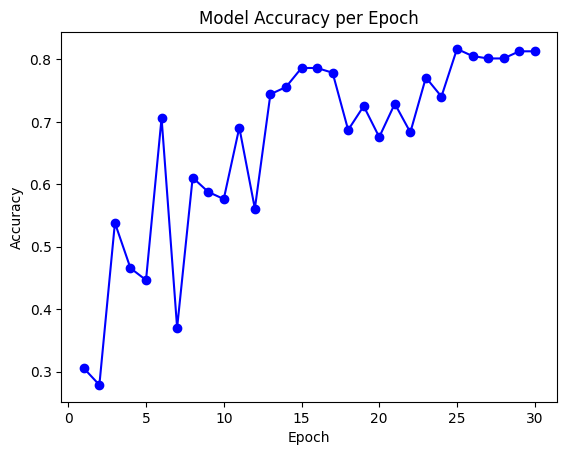

Poly Accuracy after epoch 30: 75.38%
F1 Score after last epoch: 0.7466


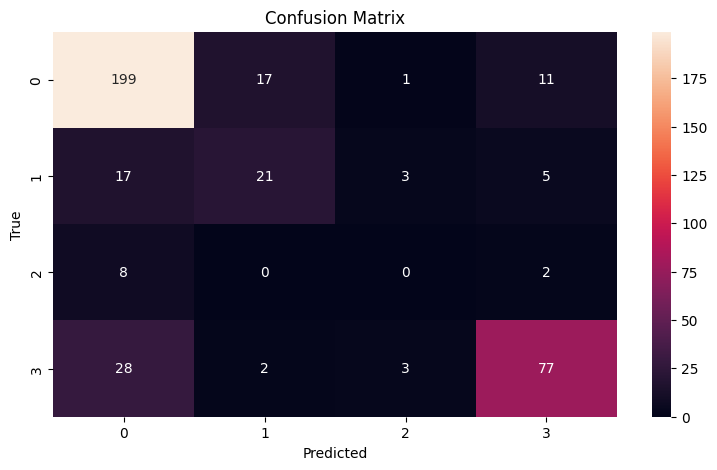

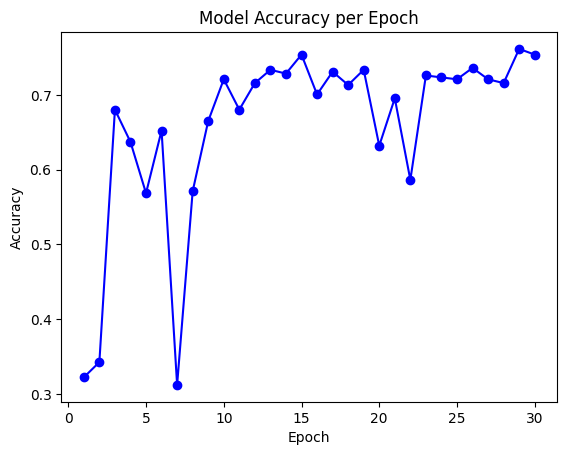

In [22]:
# Create the dataset
train_dataset = CustomDataset(images_train, labels_train, transform=transform)
test_dataset = CustomDataset(images_test, labels_test, transform=transform)
test_mono_dataset = CustomDataset(images_test_mono, labels_test_mono, transform=transform)
test_poly_dataset = CustomDataset(images_test_poly, labels_test_poly, transform=transform)



# Create data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_mono_loader = DataLoader(test_mono_dataset, batch_size=64, shuffle=False)
test_poly_loader = DataLoader(test_poly_dataset, batch_size=64, shuffle=False)


# Load the ResNet model
model = models.resnet18(pretrained=True)

# Modify the last fully connected layer to match the number of classes (4 in your case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)



counters = Counter(labels_train)
class_sample_count = [counters[0],counters[1],counters[2],counters[3]]
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
weights = weights.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


# Train the model
train_model(model,num_epochs=30)

## Train model with augmented data

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.9675574378228523
Overall Accuracy after epoch 1: 69.36%
Mono Accuracy after epoch 1: 66.41%
Poly Accuracy after epoch 1: 71.32%
Epoch 2, Loss: 0.7479103333513502
Overall Accuracy after epoch 2: 55.34%
Mono Accuracy after epoch 2: 56.49%
Poly Accuracy after epoch 2: 54.57%
Epoch 3, Loss: 0.7245826137737489
Overall Accuracy after epoch 3: 73.02%
Mono Accuracy after epoch 3: 72.14%
Poly Accuracy after epoch 3: 73.60%
Epoch 4, Loss: 0.5674375627242344
Overall Accuracy after epoch 4: 69.66%
Mono Accuracy after epoch 4: 66.41%
Poly Accuracy after epoch 4: 71.83%
Epoch 5, Loss: 0.43772505769427394
Overall Accuracy after epoch 5: 58.38%
Mono Accuracy after epoch 5: 78.24%
Poly Accuracy after epoch 5: 45.18%
Epoch 6, Loss: 0.3428451340173332
Overall Accuracy after epoch 6: 75.30%
Mono Accuracy after epoch 6: 75.95%
Poly Accuracy after epoch 6: 74.87%
Epoch 7, Loss: 0.24711878912549623
Overall Accuracy after epoch 7: 68.45%
Mono Accuracy after epoch 7: 67.94%
Poly Accuracy after

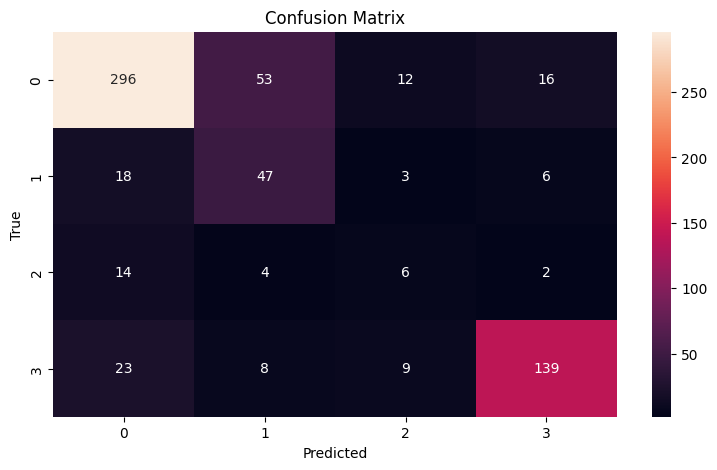

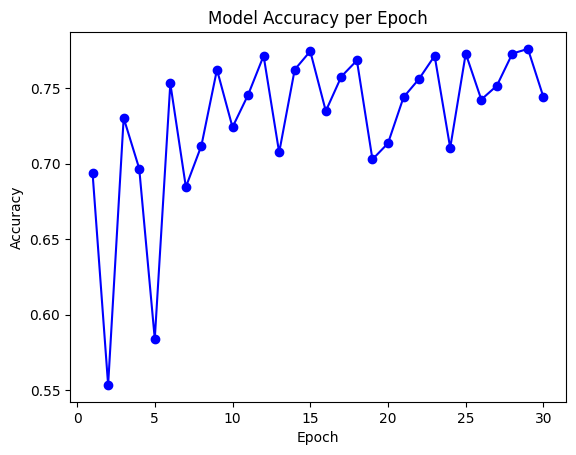

Mono Accuracy after epoch 30: 74.81%
F1 Score after last epoch: 0.7640


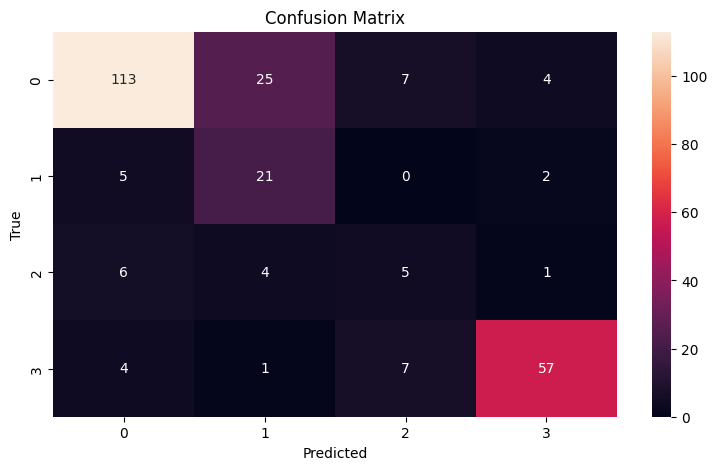

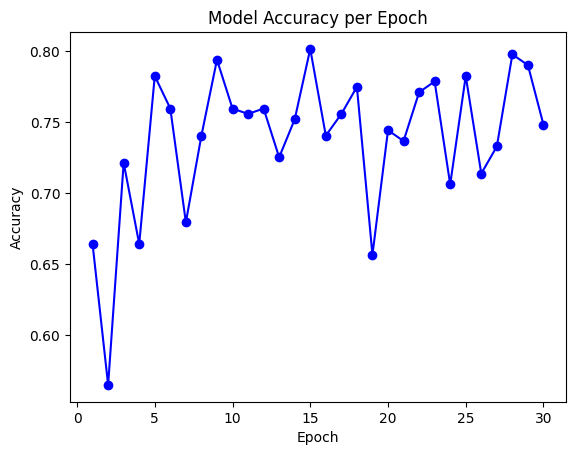

Poly Accuracy after epoch 30: 74.11%
F1 Score after last epoch: 0.7478


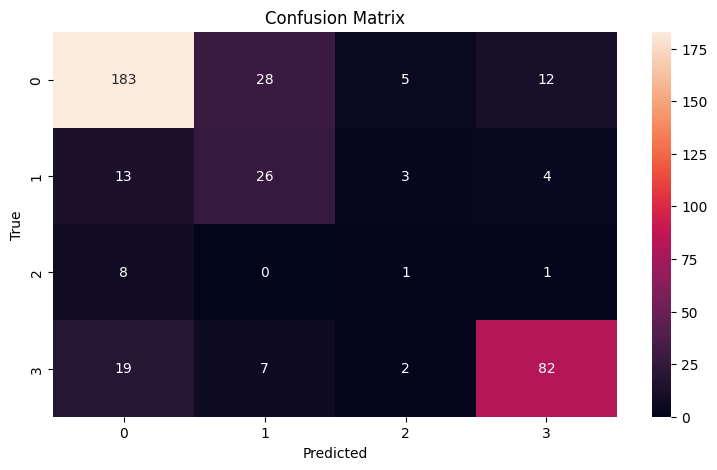

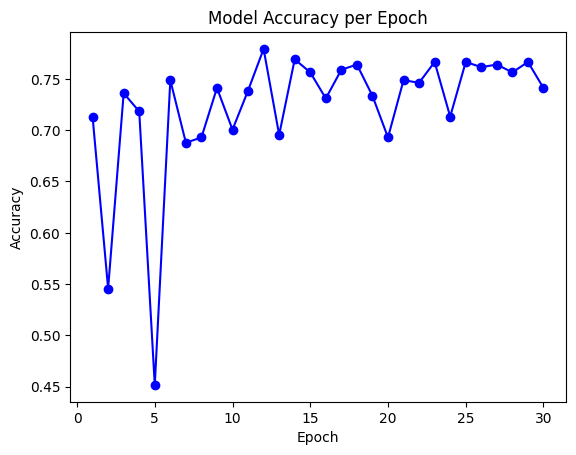

In [23]:
labels_train_aug = np.array(labels_train_aug)
# Create the dataset
train_dataset = CustomDataset(images_train_aug, labels_train_aug, transform=transform)
test_dataset = CustomDataset(images_test, labels_test, transform=transform)
test_mono_dataset = CustomDataset(images_test_mono, labels_test_mono, transform=transform)
test_poly_dataset = CustomDataset(images_test_poly, labels_test_poly, transform=transform)



# Create data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_mono_loader = DataLoader(test_mono_dataset, batch_size=64, shuffle=False)
test_poly_loader = DataLoader(test_poly_dataset, batch_size=64, shuffle=False)


# Load the ResNet model
model = models.resnet18(pretrained=True)

# Modify the last fully connected layer to match the number of classes (4 in your case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


# Train the model
train_model(model,num_epochs=30)

# Try Threshold

In [24]:
images, proba, types = load_dataset()
proba = np.around(proba, decimals=1)

In [25]:
images_threshold = []
for i in range(len(images)):
  image = images[i]
  _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  images_threshold.append(binary_image)
images = np.array(images_threshold)

In [26]:
images_train_idx, images_test_idx, labels_train, labels_test = train_test_split(
    range(len(images)), proba, test_size=0.25, random_state=42,stratify = proba)

In [27]:
# generate the training and testing data sets
labels_test_mono, labels_test_poly = split_types(images_test_idx,labels_test)
images_train_list = [images[i] for i in images_train_idx]
images_test_list = [images[i] for i in images_test_idx]
images_train = np.array(images_train_list)
images_test = np.array(images_test_list)
images_test_mono, images_test_poly = split_types(images_test_idx,images_test)

In [28]:
labels_train, labels_test, labels_test_mono, labels_test_poly = convert_label(labels_train), convert_label(labels_test), convert_label(labels_test_mono),convert_label(labels_test_poly)

In [29]:
# augment training data
images_train_aug, labels_train_aug = augment(images_train,labels_train)

In [30]:
labels_train_aug = np.array(labels_train_aug)
labels_test, labels_test_mono, labels_test_poly = np.array(labels_test), np.array(labels_test_mono), np.array(labels_test_poly)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 1.0370646312203207
Overall Accuracy after epoch 1: 53.20%
Mono Accuracy after epoch 1: 56.49%
Poly Accuracy after epoch 1: 51.02%
Epoch 2, Loss: 0.7904766256540594
Overall Accuracy after epoch 2: 59.76%
Mono Accuracy after epoch 2: 59.92%
Poly Accuracy after epoch 2: 59.64%
Epoch 3, Loss: 0.6423381017127507
Overall Accuracy after epoch 3: 59.15%
Mono Accuracy after epoch 3: 73.28%
Poly Accuracy after epoch 3: 49.75%
Epoch 4, Loss: 0.538708465619826
Overall Accuracy after epoch 4: 62.50%
Mono Accuracy after epoch 4: 72.90%
Poly Accuracy after epoch 4: 55.58%
Epoch 5, Loss: 0.4262518975096689
Overall Accuracy after epoch 5: 69.21%
Mono Accuracy after epoch 5: 67.94%
Poly Accuracy after epoch 5: 70.05%
Epoch 6, Loss: 0.3742527017291163
Overall Accuracy after epoch 6: 67.38%
Mono Accuracy after epoch 6: 64.50%
Poly Accuracy after epoch 6: 69.29%
Epoch 7, Loss: 0.38392289612494723
Overall Accuracy after epoch 7: 51.22%
Mono Accuracy after epoch 7: 66.79%
Poly Accuracy after e

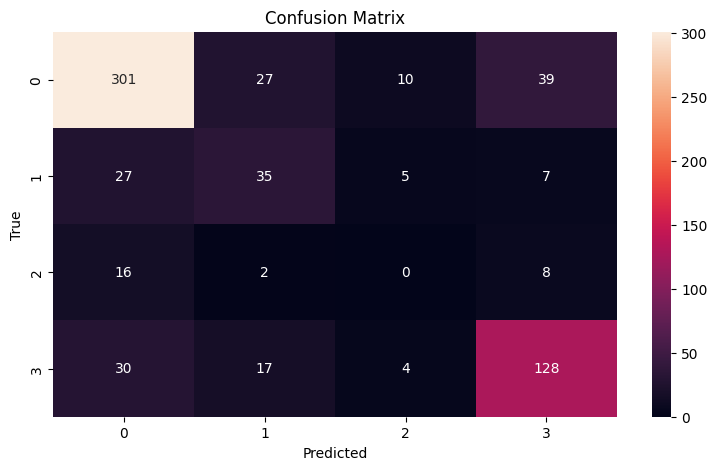

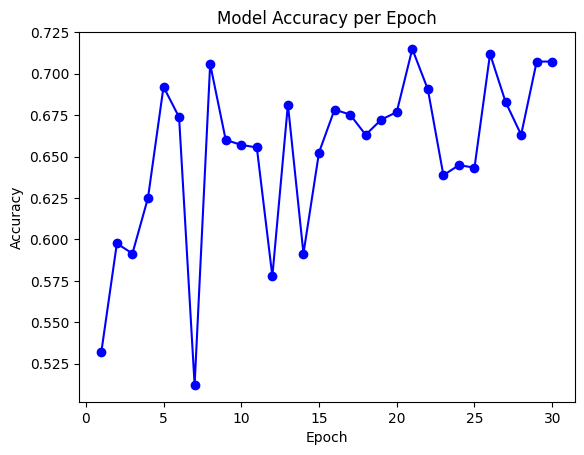

Mono Accuracy after epoch 30: 72.52%
F1 Score after last epoch: 0.7115


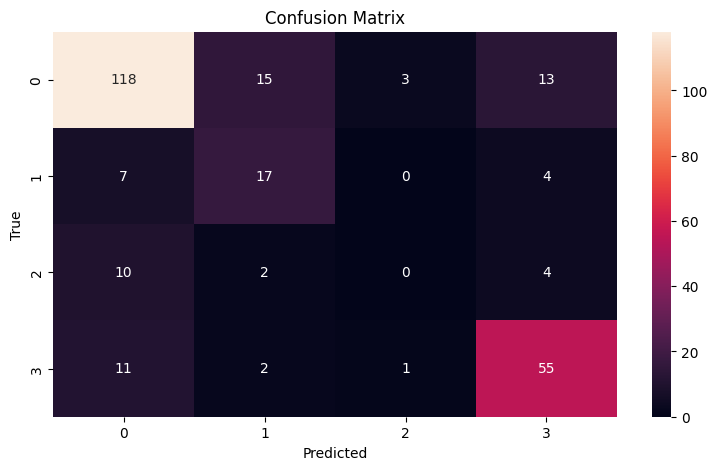

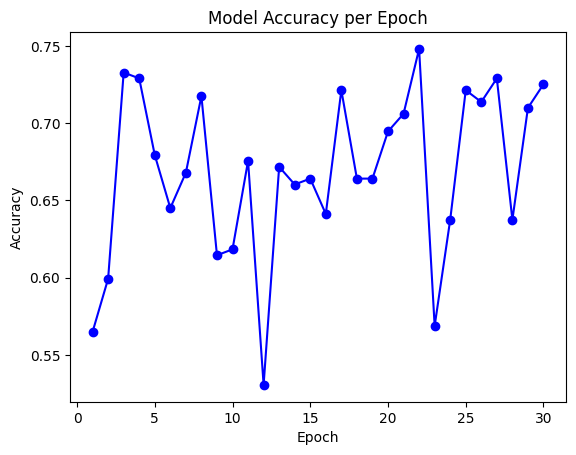

Poly Accuracy after epoch 30: 69.54%
F1 Score after last epoch: 0.6994


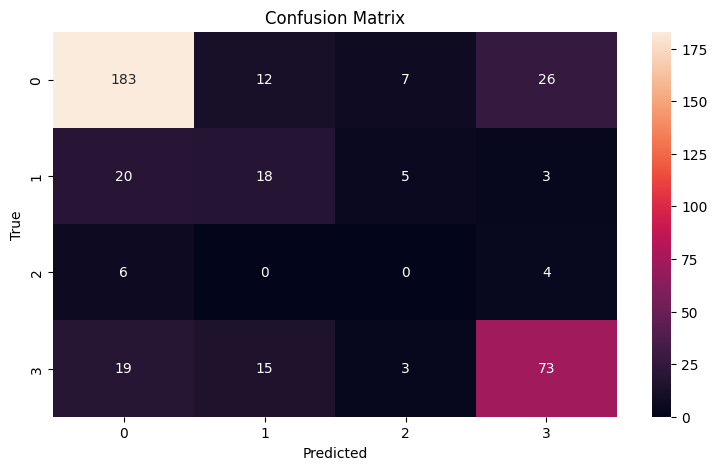

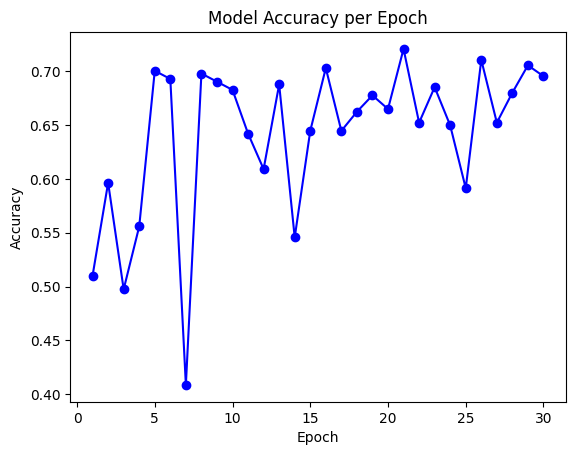

In [31]:
# Create the dataset
train_dataset = CustomDataset(images_train_aug, labels_train_aug, transform=transform)
test_dataset = CustomDataset(images_test, labels_test, transform=transform)
test_mono_dataset = CustomDataset(images_test_mono, labels_test_mono, transform=transform)
test_poly_dataset = CustomDataset(images_test_poly, labels_test_poly, transform=transform)



# Create data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_mono_loader = DataLoader(test_mono_dataset, batch_size=64, shuffle=False)
test_poly_loader = DataLoader(test_poly_dataset, batch_size=64, shuffle=False)


# Load the ResNet model
model = models.resnet18(pretrained=True)

# Modify the last fully connected layer to match the number of classes (4 in your case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


# Train the model
train_model(model,num_epochs=30)